## Project Goals
The goal of this project is to assess features of real estate to predict tax value.

## Project Description
With low interest rates and a strong buyer's market, it is increasingly important to identify valuable real estate investment opportunities. I will observe various details of properties within a few counties of California and will use the information to create a model to estimate the tax value and provide a recommendation in improving model predictions.



## Initial Questions

1. Does square footage affect tax value?
2. Do more bedrooms or bathrooms have a higher tax value?
3. Do newer houses have a higher tax value than older houses?
4. Does location affect tax value?

## Data Dictionary

| variable      | meaning       |
| ------------- |:-------------:|
|lm|Ordinary Least Squares Linear Regression modeling algorithm|
|lm2|Polynomial Regression modeling algorithm |
|lars|Lasso + Lars Regression modeling algorithm|
|df|Dataframe of raw zillow data from sql server|
|train| training dataset, a major cut from the df|
|validate| validate dataset, used to prevent overfitting|
|test| test dataset, to test the top model on unseen data|
|chi2 | statistical test used to compare churn with various categories|
|taxvaluedollarcnt| The assessed value of the built structure on the parcel|
|calculatedfinishedsquarefeet| Calculated total finished living area of the home |
|bedroomcnt| Number of bedrooms in home |
|bathroomcnt| Number of bathrooms in home including fractional bathrooms|
|fips| County codes for property locations|
| County Codes||
|6037 | Los Angeles, CA|
|6059 | Orange, CA|
|6111 | Ventura, CA|

## Wrangle Zillow Data
To acquire the zillow data used, I ran a query on the zillow database from the mySQL server. I selected the bed, bath, finished square feet, tax value, year built, taxamount, and fips columns from the properties_2017 table, referencing the propertylandusetype table to retrieve the single family homes. By joining the predictions_2017 table I was able to exclude properties that did not have transactions in 2017.

In [1]:
# import modules
import pandas as pd

# import visualizations
import viz

# ignore warnings to reduce clutter
import warnings
warnings.filterwarnings("ignore")

# Import wrangle module with functions to acquire, prepare, scale, and split data from SQL server's zillow database
import wrangle

# execute the function and store it in train, validate, and test dataframes
train, validate, test = wrangle.wrangle_zillow()

Cleaning the data was executed in the following steps:
- Drop duplicates
- Removed outliers
- Create scaled columns of data
- Drop unnecessary columns

## Our Data Landscape
- Properties that had transactions in 2017.
- 45,241 properties assessed after data cleaning.
- Located throughout three California counties.
- With outliers removed, I analyzed properties with 2-5 bedrooms and 1-4 bathrooms.


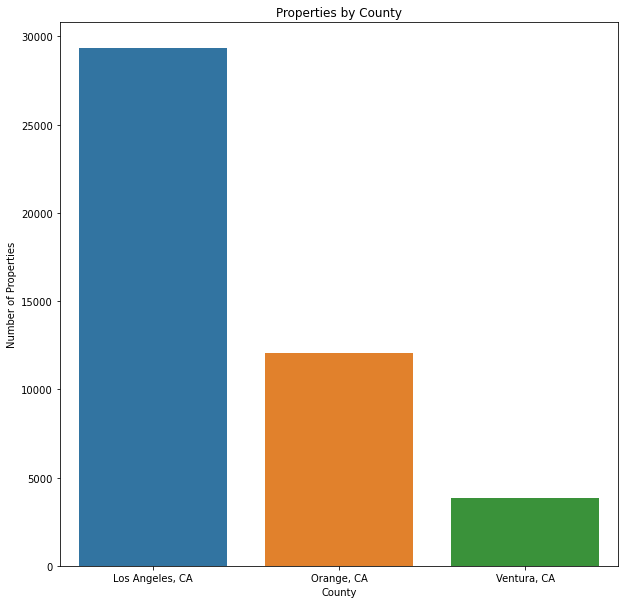

In [2]:
# visualize the number of properties in each county after data cleaning.
viz.data_landscape()

## Exploratory analysis: What correlates with tax value?

All statistic tests are in the statistics module, attached for your convenience.

### 1. Do houses with higher square footage have a higher calculated tax amount?

- Run a independent T-Test to test high and low square footage tax values

In [3]:
# import module with statistics
import statistics

# run T-Test
statistics.t_test_sqft_tax(train)


Higher square footage properties generally have a higher calculated tax amount.


### 2. Do houses with more bathrooms have a higher calculated tax amount?

- Run an independent T-Test to test high and low bathrooms tax values

In [4]:
statistics.t_test_bath_tax(train)

There is no statistical evidence that higher bathroom count properties have higher tax values than lower bathroom count properties.


### 3. Do houses with more bedrooms have a higher calculated tax amount?

- Run an independent T-Test to test high and low bathrooms tax values

In [5]:
statistics.t_test_bed_tax(train)

There is no statistical evidence that higher bedroom count properties have higher tax values than lower bedroom count properties


### 4. Do houses with less bedrooms and higher square footage have a higher tax value than houses with more bedrooms and a lower square footage?
- I calculated the means for the two categories above and plotted their differences.

The mean tax value for properties with less than three bedrooms and more than 2000 square feet is 527221, 
The mean tax value for properties with three or more bedrooms and less than 2000 square feet is 322301.


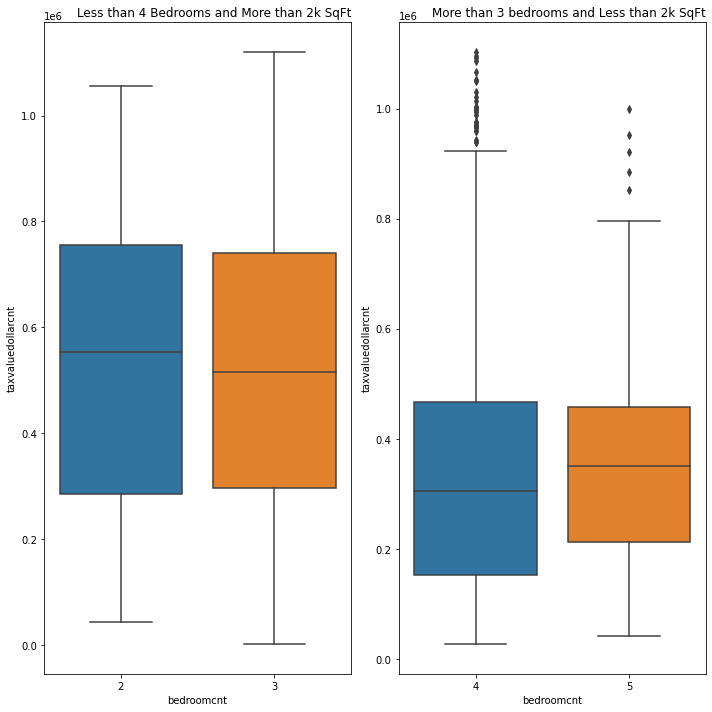

(None, None)

In [6]:
statistics.test_lowbed_highsqf(train)

Houses with more sq ft and less rooms are generally worth more than houses with more bedrooms and less sq ft. This implies a larger impact on value from sq ft than bedrooms.

### 5. Do newer houses cost more than older houses?
- I ran a chi2 test to discover if the house's age correlates to its tax value.
- Plot a line plot to compare the tax value and the year built

There is a correlation between year built and tax value.


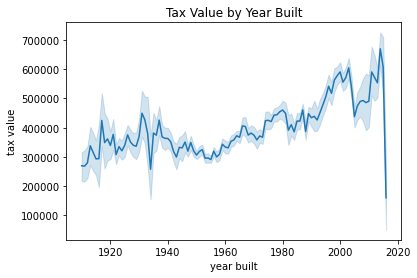

(None, None)

In [7]:
statistics.test_year_built(train)

### 6. Do individual fips have higher average tax value?
- Run a chi2 test to discover if the county correlates to tax value

In [8]:
statistics.test_fips(train)

There is a correlation between fips and tax value.


## So what affects tax value?
Through statistical tests I've noted that the calculated square feet has a greater impact on the tax value than the number of bedrooms and bathrooms. I also observed that the location of the property and the year the property was built have their own affects on the tax value.

## Modeling: Predicting tax values
I am using linear regression algorithms to predict a continous target variable. The models will be fit on a training dataset and then validated with a separate dataset to ensure there is no overfitting. The primary measure of model performance I will be using is Explained Variance. RMSE is included for your reference.

In [9]:
#import linear regression modules
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

#import evaluation metrics
from sklearn.metrics import mean_squared_error, explained_variance_score

### Create X and y for modeling purposes.

In [10]:
# X_train with the target dropped
X_train = train.drop(columns=['taxvaluedollarcnt','taxvaluedollarcnt_scaled', 'calculatedfinishedsquarefeet_scaled','bedroomcnt_scaled','bathroomcnt_scaled'])
# scaled only version of X_train
X_train_scaled = train.drop(columns=['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','taxvaluedollarcnt','yearbuilt','fips','taxvaluedollarcnt_scaled'])
# Series containing target
y_train = train.taxvaluedollarcnt

# Unscaled, scaled, and series containing target for validate
X_validate = validate.drop(columns=['taxvaluedollarcnt','taxvaluedollarcnt_scaled', 'calculatedfinishedsquarefeet_scaled','bedroomcnt_scaled','bathroomcnt_scaled'])
X_validate_scaled = train.drop(columns=['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','taxvaluedollarcnt','yearbuilt','fips', 'taxvaluedollarcnt_scaled'])
y_validate = validate.taxvaluedollarcnt

# Unscaled, scaled, and series containing target for test
X_test = test.drop(columns=['taxvaluedollarcnt','taxvaluedollarcnt_scaled', 'calculatedfinishedsquarefeet_scaled','bedroomcnt_scaled','bathroomcnt_scaled'])
X_test_scaled = train.drop(columns=['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','taxvaluedollarcnt','yearbuilt','fips', 'taxvaluedollarcnt_scaled'])
y_test = test.taxvaluedollarcnt

## Baseline
A baseline is created by evaluating the mean tax value for all properties.

In [11]:
# Create dataframes of the target for modeling purposes
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# predict mean
pred_mean = y_train.taxvaluedollarcnt.mean()
y_train['baseline_pred_mean'] = pred_mean
y_validate['baseline_pred_mean'] = pred_mean

# RMSE of mean
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.baseline_pred_mean)**(1/2)
print("Train/In-Sample RMSE: ", round(rmse_train, 2))
# evs of mean
evs = explained_variance_score(y_train.taxvaluedollarcnt, y_train.baseline_pred_mean)
print('Explained Variance of Mean Baseline: ', round(evs,3))

# validate rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.baseline_pred_mean)**(1/2)
print("Validate/Out-of-Sample RMSE: ", round(rmse_validate, 2))
# validate evs
evs = explained_variance_score(y_train.taxvaluedollarcnt, y_train.baseline_pred_mean)
print('Explained Variance of Mean Baseline: ', round(evs,3))

Train/In-Sample RMSE:  245330.65
Explained Variance of Mean Baseline:  0.0
Validate/Out-of-Sample RMSE:  245581.31
Explained Variance of Mean Baseline:  0.0


## Three Models
The models I created were an Ordinary Least Squares Linear Regression Model, Polynomial Linear Regression Model, and a Lasso Lars Linear Regression Model. The best performing model was the Lasso Lars model. 

## OLS Model

In [12]:
# Create model
lm = LinearRegression(normalize=True,)

# fit the model to training data.
lm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvalue_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_lm)**(1/2)

print("Training/In-Sample RMSE: ", rmse_train)
evs = explained_variance_score(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_lm)
print('Train Explained Variance: ', round(evs,3))

Training/In-Sample RMSE:  217427.46757616082
Train Explained Variance:  0.215


### Evaluate on Validate

In [13]:
# predict validate
y_validate['taxvalue_pred_lm'] = lm.predict(X_validate)

# evaluate rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lm)**(1/2)

# evaluate evs
evs = explained_variance_score(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lm)
print("Validation/Out-of-Sample RMSE:", rmse_validate,'\nValidate Explained Variance: ', round(evs,3))

Validation/Out-of-Sample RMSE: 217917.3701953839 
Validate Explained Variance:  0.213


## Polynomial Model

In [14]:
# create a new set of polynomial features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

# create the model
lm2 = LinearRegression(normalize=True)

# fit the model to training data
lm2.fit(X_train_degree2, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvalue_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_lm2)**(1/2)
print('Training/In-Sample: ', rmse_train)
# evaluate evs
evs = explained_variance_score(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_lm2)
print('Train Explained Variance = ', round(evs,3))


Training/In-Sample:  213662.73045560464
Train Explained Variance =  0.242


### Evaluate on Validate

In [15]:
# predict validate
y_validate['taxvalue_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lm2)**(1/2)

# evaluate evs
evs = explained_variance_score(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lm2)
print('Validation/Out-of-Sample:', rmse_validate, '\nValidate Explained Variance: ', round(evs,3))

Validation/Out-of-Sample: 213919.34634348727 
Validate Explained Variance:  0.241


## LassoLars Model

In [16]:
# create the model
lars = LassoLars(alpha=50)

# fit the model to training data
lars.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvalue_pred_lars'] = lars.predict(X_train)

# evaluate rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_lars)**(1/2)

print("Training/In-Sample: ", rmse_train)

evs = explained_variance_score(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_lars)
print('Train Explained Variance = ', round(evs,3))

Training/In-Sample:  218421.32822113534
Train Explained Variance =  0.207


### Evaluate on Validate

In [17]:
# predict validate
y_validate['taxvalue_pred_lars'] = lars.predict(X_validate)

# evaluate rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lars)**(1/2)
# evaluate evs
evs = explained_variance_score(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lars)
print('Validation/Out-of-Sample: ', rmse_validate, '\nValidate Explained Variance = ', round(evs,3))

Validation/Out-of-Sample:  218899.52054395145 
Validate Explained Variance =  0.205


## Validating with Visuals

A scatter plot of each models' predictions vs the actual tax values. The ideal line for my predictions is plotted for reference. There is a lot of overlap, but there is a slightly better fit for the polynomial model, displayed in yellow.

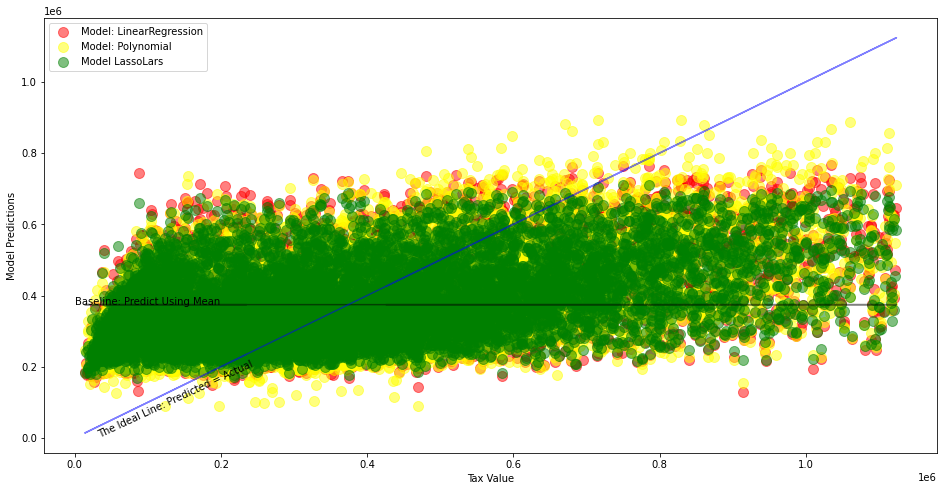

In [18]:
viz.validate_scatter(y_validate, pred_mean)

Similarly to the scatterplot, the polynomial model's histogram compared to the other models' is slightly more fit to the actual values.

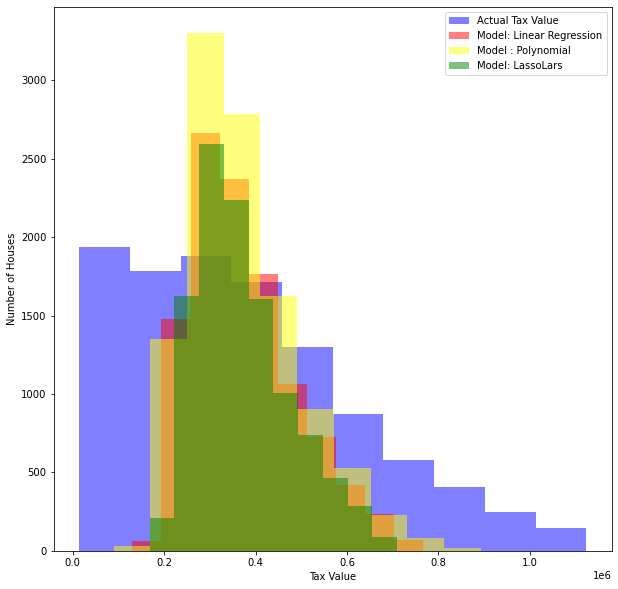

In [19]:
viz.validate_hist(y_validate)

## Evaluate on Test
The polynomial model performed the best of the three models and will be evaluated on the test dataset.

In [20]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['taxvalue_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.taxvaluedollarcnt, y_test.taxvalue_pred_lm2)**(1/2)

print("Out-of-Sample Performance RMSE: ", rmse_test)

evs = explained_variance_score(y_test.taxvaluedollarcnt, y_test.taxvalue_pred_lm2)
print('Test Explained Variance = ', round(evs,3))

Out-of-Sample Performance RMSE:  209851.92910582214
Test Explained Variance =  0.248


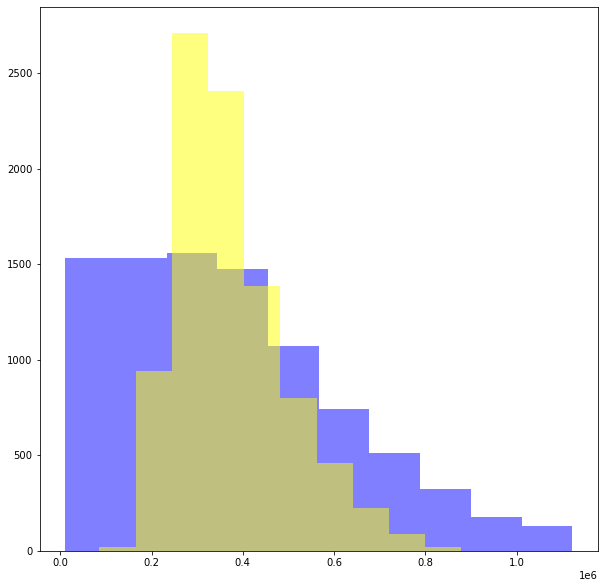

In [21]:
viz.test_hist(y_test)

## Conclusion
### Summary
#### What features matter?
Through statistical analysis of the features I analyzed, I've identified that the square footage weighs heaviest on the tax value than the other features.

#### Modeling
The data was modeled through three different linear regression algorithms, with the Polynomial Regression model being the top performer. The model performed as well as it had in training in the validation data and slightly better in the test dataset.

### Recommendations
My recommendation to improve predictions is to use more refined models that explore more features of the properties, aiming to become a more accurate model.

### Next Steps
To improve modeling, retreiving more data of the properties from the database to explore and assess whether they would be beneficial to include in modeling. I would also like to spend more time running statistical tests to verify relationships of features. 